In [1]:
import numpy as np
import bilby 
import pycbc 
import sys
import matplotlib.pyplot as plt
import pandas as pd
from glasflow import RealNVP, CouplingNSF

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn

import pickle
from sklearn.decomposition import IncrementalPCA
import sklearn.decomposition 
import os
import json
import glob



<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/home/qian.hu/.conda/envs/myigwn-py39/lib/python3.9/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(True)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


In [37]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
#from .utils import PARAMETER_NAMES_ALL_PRECESSINGBNS_BILBY
from river.models.utils import *
from river.data.utils import *

import river.data
from river.data.datagenerator import DataGeneratorBilbyFD
from river.data.dataset import DatasetSVDStrainFDFromSVDWFonGPU, DatasetSVDStrainFDFromSVDWFonGPUBatch
#import river.data.utils as datautils
from river.data.utils import *

from river.models import embedding
from river.models.utils import *
#from river.models.embedding.pca import project_strain_data_FDAPhi
from river.models.embedding.conv import EmbeddingConv1D, EmbeddingConv2D
from river.models.embedding.mlp import EmbeddingMLP1D
from river.models.inference.cnf import GlasflowEmbdding

# Make test data

In [3]:
source_type = 'BNS'
detector_names = ['H1', 'L1', 'V1'] 
duration = 32
f_low = 50
f_high = 1024

f_ref = 20
sampling_frequency = 2048
waveform_approximant = 'IMRPhenomPv2_NRTidal'
parameter_names = PARAMETER_NAMES_ALL_PRECESSINGBNS_BILBY
PSD_type = 'bilby_default' #'zero_noise' bilby_default
use_sealgw_detector = True

Vhfile="/home/qian.hu/mlpe/river/test/outputs/Vh_50Hz1024Hz32s.pickle"

data_generator = DataGeneratorBilbyFD(source_type,
            detector_names, 
            duration, 
            f_low, 
            f_ref, 
            sampling_frequency, 
            waveform_approximant, 
            parameter_names,
            PSD_type=PSD_type,
            use_sealgw_detector=use_sealgw_detector,
            f_high=f_high)

21:58 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


Using bilby_default PSDs to generate data.


In [99]:
validfolder = '/home/qian.hu/mlpe/training_data/bns_50Hz1024Hz32s_lowspin_lb/valid'
trainfolder = '/home/qian.hu/mlpe/training_data/bns_50Hz1024Hz32s_lowspin_lb/train'
#noisefolder = '/home/qian.hu/mlpe/training_data/bns_50Hz1024Hz32s_lowspin/noise/design'

valid_filenames = glob.glob(f"{validfolder}/batch*/*.h5")
train_filenames = glob.glob(f"{trainfolder}/batch*/*.h5")

dataset_valid = DatasetSVDStrainFDFromSVDWFonGPU(valid_filenames, PARAMETER_NAMES_CONTEXT_PRECESSINGBNS_BILBY, data_generator,
                                     Nbasis=512, Vhfile=Vhfile, fix_extrinsic=True)
#dataset_train = DatasetSVDStrainFDFromSVDWFonGPU(train_filenames[:1], PARAMETER_NAMES_CONTEXT_PRECESSINGBNS_BILBY, data_generator,
#                                     Nbasis=512, Vhfile=Vhfile, fix_extrinsic=True)
    
dataset_train = DatasetSVDStrainFDFromSVDWFonGPUBatch(train_filenames[:1], PARAMETER_NAMES_CONTEXT_PRECESSINGBNS_BILBY, data_generator,
                                     Nbasis=512, Vhfile=Vhfile, fix_extrinsic=True)



In [5]:
detector_names = config_datagenerator['detector_names']

Ntest = 2
injection_parameters_test = generate_BNS_injection_parameters(Nsample = 2*Ntest, **config_datagenerator)
data_generator_test = DataGeneratorBilbyFD(**config_datagenerator)


00:54 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


Using bilby_default PSDs to generate data.


In [6]:
data_generator_test.inject_signals(injection_parameters_test, 2*Ntest, Ntest)
data_generator_test.numpy_starins()

Injecting 0-th signal, 0.0% done
Injecting 1-th signal, 25.0% done


In [7]:
data_generator_test.data['strains']['H1'].shape

(2, 321281)

In [8]:
x = project_data(data_generator_test, ipca_gen, detector_names)

data_dict = {}
data_dict['x'] = x.numpy()
data_dict['injection_parameters'] = data_generator_test.data['injection_parameters']



In [26]:
dataset_test = DatasetXFromPreCalSVDData(precaldata_list=[data_dict],  parameter_names=config_datagenerator['context_parameter_names'])


def read_in_x(filename_list, Nsample=1e20):
    x_list = []
    for filename in filename_list:
        if len(x_list)*200>Nsample:
            break
        x_list.append(load_dict_from_hdf5(filename))
    return x_list

valid_precaldata_filelist = glob.glob(f"{config['precaldata_parameters']['valid']['folder']}/batch*/*.h5")
valid_precaldata_list = read_in_x(valid_precaldata_filelist, Nsample=3)
dataset_valid = DatasetXFromPreCalSVDData(precaldata_list=valid_precaldata_list,  parameter_names=config_datagenerator['context_parameter_names'])



In [9]:
len(dataset_test)

2

In [10]:
#batch_size = 1
#test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

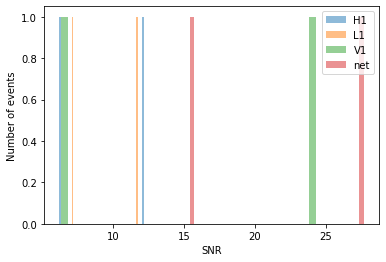

In [9]:

for key, values in data_generator_test.data['SNRs'].items():
    _ = plt.hist(values, label=key, alpha=0.5, bins=40)
_ = plt.hist((data_generator_test.data['SNRs']['H1']**2 + data_generator_test.data['SNRs']['L1']**2 + data_generator_test.data['SNRs']['V1']**2 )**0.5,
                label='net', alpha=0.5, bins=40)
plt.legend()
plt.xlabel('SNR')
plt.ylabel('Number of events')
plt.show()

In [10]:
(data_generator_test.data['SNRs']['H1']**2 + data_generator_test.data['SNRs']['L1']**2 + data_generator_test.data['SNRs']['V1']**2 )**0.5

array([15.39624868, 27.69616012])

# Load model

In [100]:
config_path = '/home/qian.hu/mlpe/river/scripts/trained_models/BNS50102432_RealImag_Conv1D_1M'
with open(f"{config_path}/config.json", 'r') as f:
        config_dict = json.load(f)

device='cuda'
model = GlasflowEmbdding(config_dict).to(device)


Initialized MLP in channel: 482


In [101]:
ckpt_dir = config_dict['ckpt_dir']
ckpt_path = f'{ckpt_dir}/checkpoint.pickle'

In [102]:

checkpoint = torch.load(ckpt_path, map_location=device)
start_epoch = checkpoint['epoch']
model.load_state_dict(checkpoint['model_state_dict']) 

print(f'Loaded states from {ckpt_path}, epoch={start_epoch}.')

Loaded states from trained_models/BNS50102432_RealImag_Conv1D_1M/checkpoint.pickle, epoch=9.


In [103]:
dataset_valid[0][1].shape

torch.Size([6, 512])

In [104]:
def mysample_GlasNSFWarpper(model, dataset, detector_names=None, ipca_gen=None, device='cpu', Nsample=5000, max_event=1e3):
    model.eval()
    loss_list = []
    sample_list = []
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
    with torch.no_grad():
        i = 0
        for theta, x in dataloader:
            theta = theta.to(device)
            x = x.to(device)
            
            if type(dataset) == DatasetSVDStrainFDFromSVDWFonGPUBatch:
                print('w3')
                theta = theta.view(dataset.minibatch_size, theta.shape[-1])
                x = x.view(dataset.minibatch_size, x.shape[-2], x.shape[-1])
            #x = project_strain_data_FDAPhi(strain, psd, detector_names, ipca_gen).to(device)
            #loss = -model.log_prob(theta, x).mean()

            lenx = x.shape[-1]
            lentheta = theta.shape[-1]
            loss = -model.log_prob(theta, x=x).mean()
            samples = model.sample(Nsample, x=x)


            loss_list.append(loss.detach().cpu())
            sample_list.append(samples.cpu().numpy())
            i+=1
            if i>=max_event:
                break
    samples = np.array(sample_list)
    samples = torch.from_numpy(samples)

    return samples.movedim(1,2), loss_list


In [119]:
for i in range(64):
    dataset_train = DatasetSVDStrainFDFromSVDWFonGPUBatch(train_filenames[i:i+1], PARAMETER_NAMES_CONTEXT_PRECESSINGBNS_BILBY, data_generator,
                                     Nbasis=512, Vhfile=Vhfile, fix_extrinsic=True)
    sample_list, loss_list =  mysample_GlasNSFWarpper(model, dataset_train, device=device, Nsample=5000, max_event=10)
    if min(loss_list) < 100:
        break

w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w3
w

In [117]:
sample_list, loss_list =  mysample_GlasNSFWarpper(model, dataset_train, device=device, Nsample=5000, max_event=10)

w3
w3
w3
w3
w3
w3
w3
w3
w3
w3


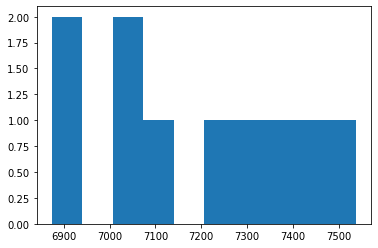

In [120]:
_ = plt.hist(loss_list)

In [86]:
def make_results(sample_list, parameter_names, injection_parameters_list=None):
    Nresult = len(sample_list)

    result_list = []
    for i in range(Nresult):
        result = bilby.gw.result.CompactBinaryCoalescenceResult()
        injection_parameters = {}
        posterior_dict = {}
        search_parameter_keys = []
        parameter_labels_with_unit = []
        for j,paraname in enumerate(parameter_names):
            if injection_parameters_list is None:
                injection_parameters[paraname] = 0
            posterior_dict[paraname] = np.array(sample_list[i][j].cpu())
            search_parameter_keys.append(paraname)
            parameter_labels_with_unit.append(paraname)
        
        result.posterior = pd.DataFrame.from_dict(posterior_dict)
        result.injection_parameters = injection_parameters
        result.search_parameter_keys = search_parameter_keys
        result.parameter_labels_with_unit = parameter_labels_with_unit
        result_list.append(result)
    
    return result_list

In [87]:
result_list = make_results(sample_list, PARAMETER_NAMES_CONTEXT_PRECESSINGBNS_BILBY)

/home/qian.hu/mlpe/river/river/models/utils.py:585: RuntimeWarning: invalid value encountered in true_divide
  lower = scipy.stats.binom.ppf(1 - edge_of_bound, N, x_values) / N
/home/qian.hu/mlpe/river/river/models/utils.py:586: RuntimeWarning: invalid value encountered in true_divide
  upper = scipy.stats.binom.ppf(edge_of_bound, N, x_values) / N
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


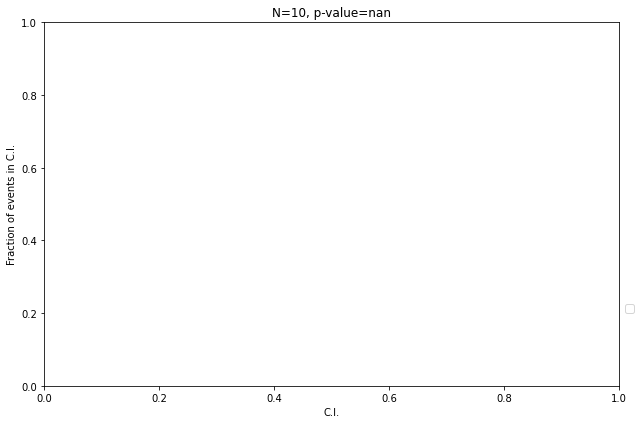

In [88]:
#fig = bilby.core.result.make_pp_plot(result_list, filename=None, save=False, confidence_interval=[0.68, 0.95, 0.997])
fig = make_pp_plot(result_list, filename = f"{config_path}/pp_plot.png", save=True, confidence_interval=[0.68, 0.95, 0.997])

In [89]:
look_index = 1
result = result_list[look_index]

In [90]:
np.argmin(loss_list)

4

In [91]:
result.posterior

chirp_mass  mass_ratio       a_1       a_2    tilt_1    tilt_2  \
0       1.787814   -1.175596  0.052850  0.057544  0.532200  1.682740   
1       1.556803    0.428330  0.018903  0.057045  2.784361  2.377415   
2       1.443854    0.372359  0.051514  0.086207  2.000446  1.668168   
3       1.581569    0.746240  0.049959  0.086589  1.789711  0.582244   
4       2.168155    0.986719  0.004164  0.013942  0.920755  1.539397   
...          ...         ...       ...       ...       ...       ...   
4995    1.500372    0.103854  0.008659  0.019089  1.223367  1.916161   
4996    2.102071    0.560953  0.051567  0.082396  1.113033  1.544696   
4997    1.789046    0.395490  0.066796  0.018370  2.661796  1.893310   
4998    1.620917    0.998499  0.065504  0.061056  1.345881  1.789042   
4999    1.657682    0.251102  0.024392  0.050636  2.926425  1.862002   

        phi_12    phi_jl  lambda_tilde  delta_lambda_tilde  theta_jn  \
0     2.158987  5.154682   6152.530762         -352.757965  2.137781   
1     2.201578  5.268713   4580.672852         -998.374878  2.416581   
2     5.314044  7.142724   3046.337646         -893.925903  1.898137   
3     4.753864  3.946179   3617.192139           88.500946  2.103000   
4     0.697304  1.631591   3556.981445         -451.637299  1.084362   
...        ...       ...           ...                 ...       ...   
4995  2.942771  2.789654   4819.764648        -1189.407104  1.891595   
4996  3.383782  5.748673   1520.801636         -238.620529  1.049362   
4997  6.046569  4.967661   3509.205322        -1125.753662  1.857291   
4998  3.827155  6.084202   2193.512207         -156.006500  0.321390   
4999  3.175946  5.184090   5315.058594        -1485.209839  1.114336   

      luminosity_distance        ra  dec  psi     phase  geocent_time  
0               45.190090  0.999998  1.0  1.0  1.688288 -8.598911e-07  
1              172.870514  0.999998  1.0  1.0  2.422542 -1.464151e-06  
2               42.996803  0.999998  1.0  1.0  0.471694 -1.293449e-06  
3               15.865532  0.999999  1.0  1.0  5.437330 -1.034780e-06  
4               30.834564  0.999999  1.0  1.0  4.607152 -1.291218e-06  
...                   ...       ...  ...  ...       ...           ...  
4995            36.873390  0.999998  1.0  1.0  0.341977 -1.495310e-06  
4996           122.448082  0.999998  1.0  1.0  4.806048 -1.428418e-06  
4997           106.945251  0.999998  1.0  1.0  2.494446 -1.309607e-06  
4998            91.537376  0.999998  1.0  1.0  3.862362 -1.280928e-06  
4999            62.957893  0.999998  1.0  1.0  6.236473 -1.291397e-06  

[5000 rows x 17 columns]

In [92]:
dataset_valid[0][0]

tensor([ 1.5416e+00,  6.8445e-01,  4.4207e-02,  1.2450e-02,  2.0082e+00,
         1.9717e+00,  9.8207e-01,  5.4795e-01,  1.2954e+03, -9.3296e+01,
         1.6181e+00,  2.4962e+01,  1.0000e+00,  1.0000e+00,  1.0000e+00,
         1.9039e+00,  0.0000e+00], device='cuda:0')

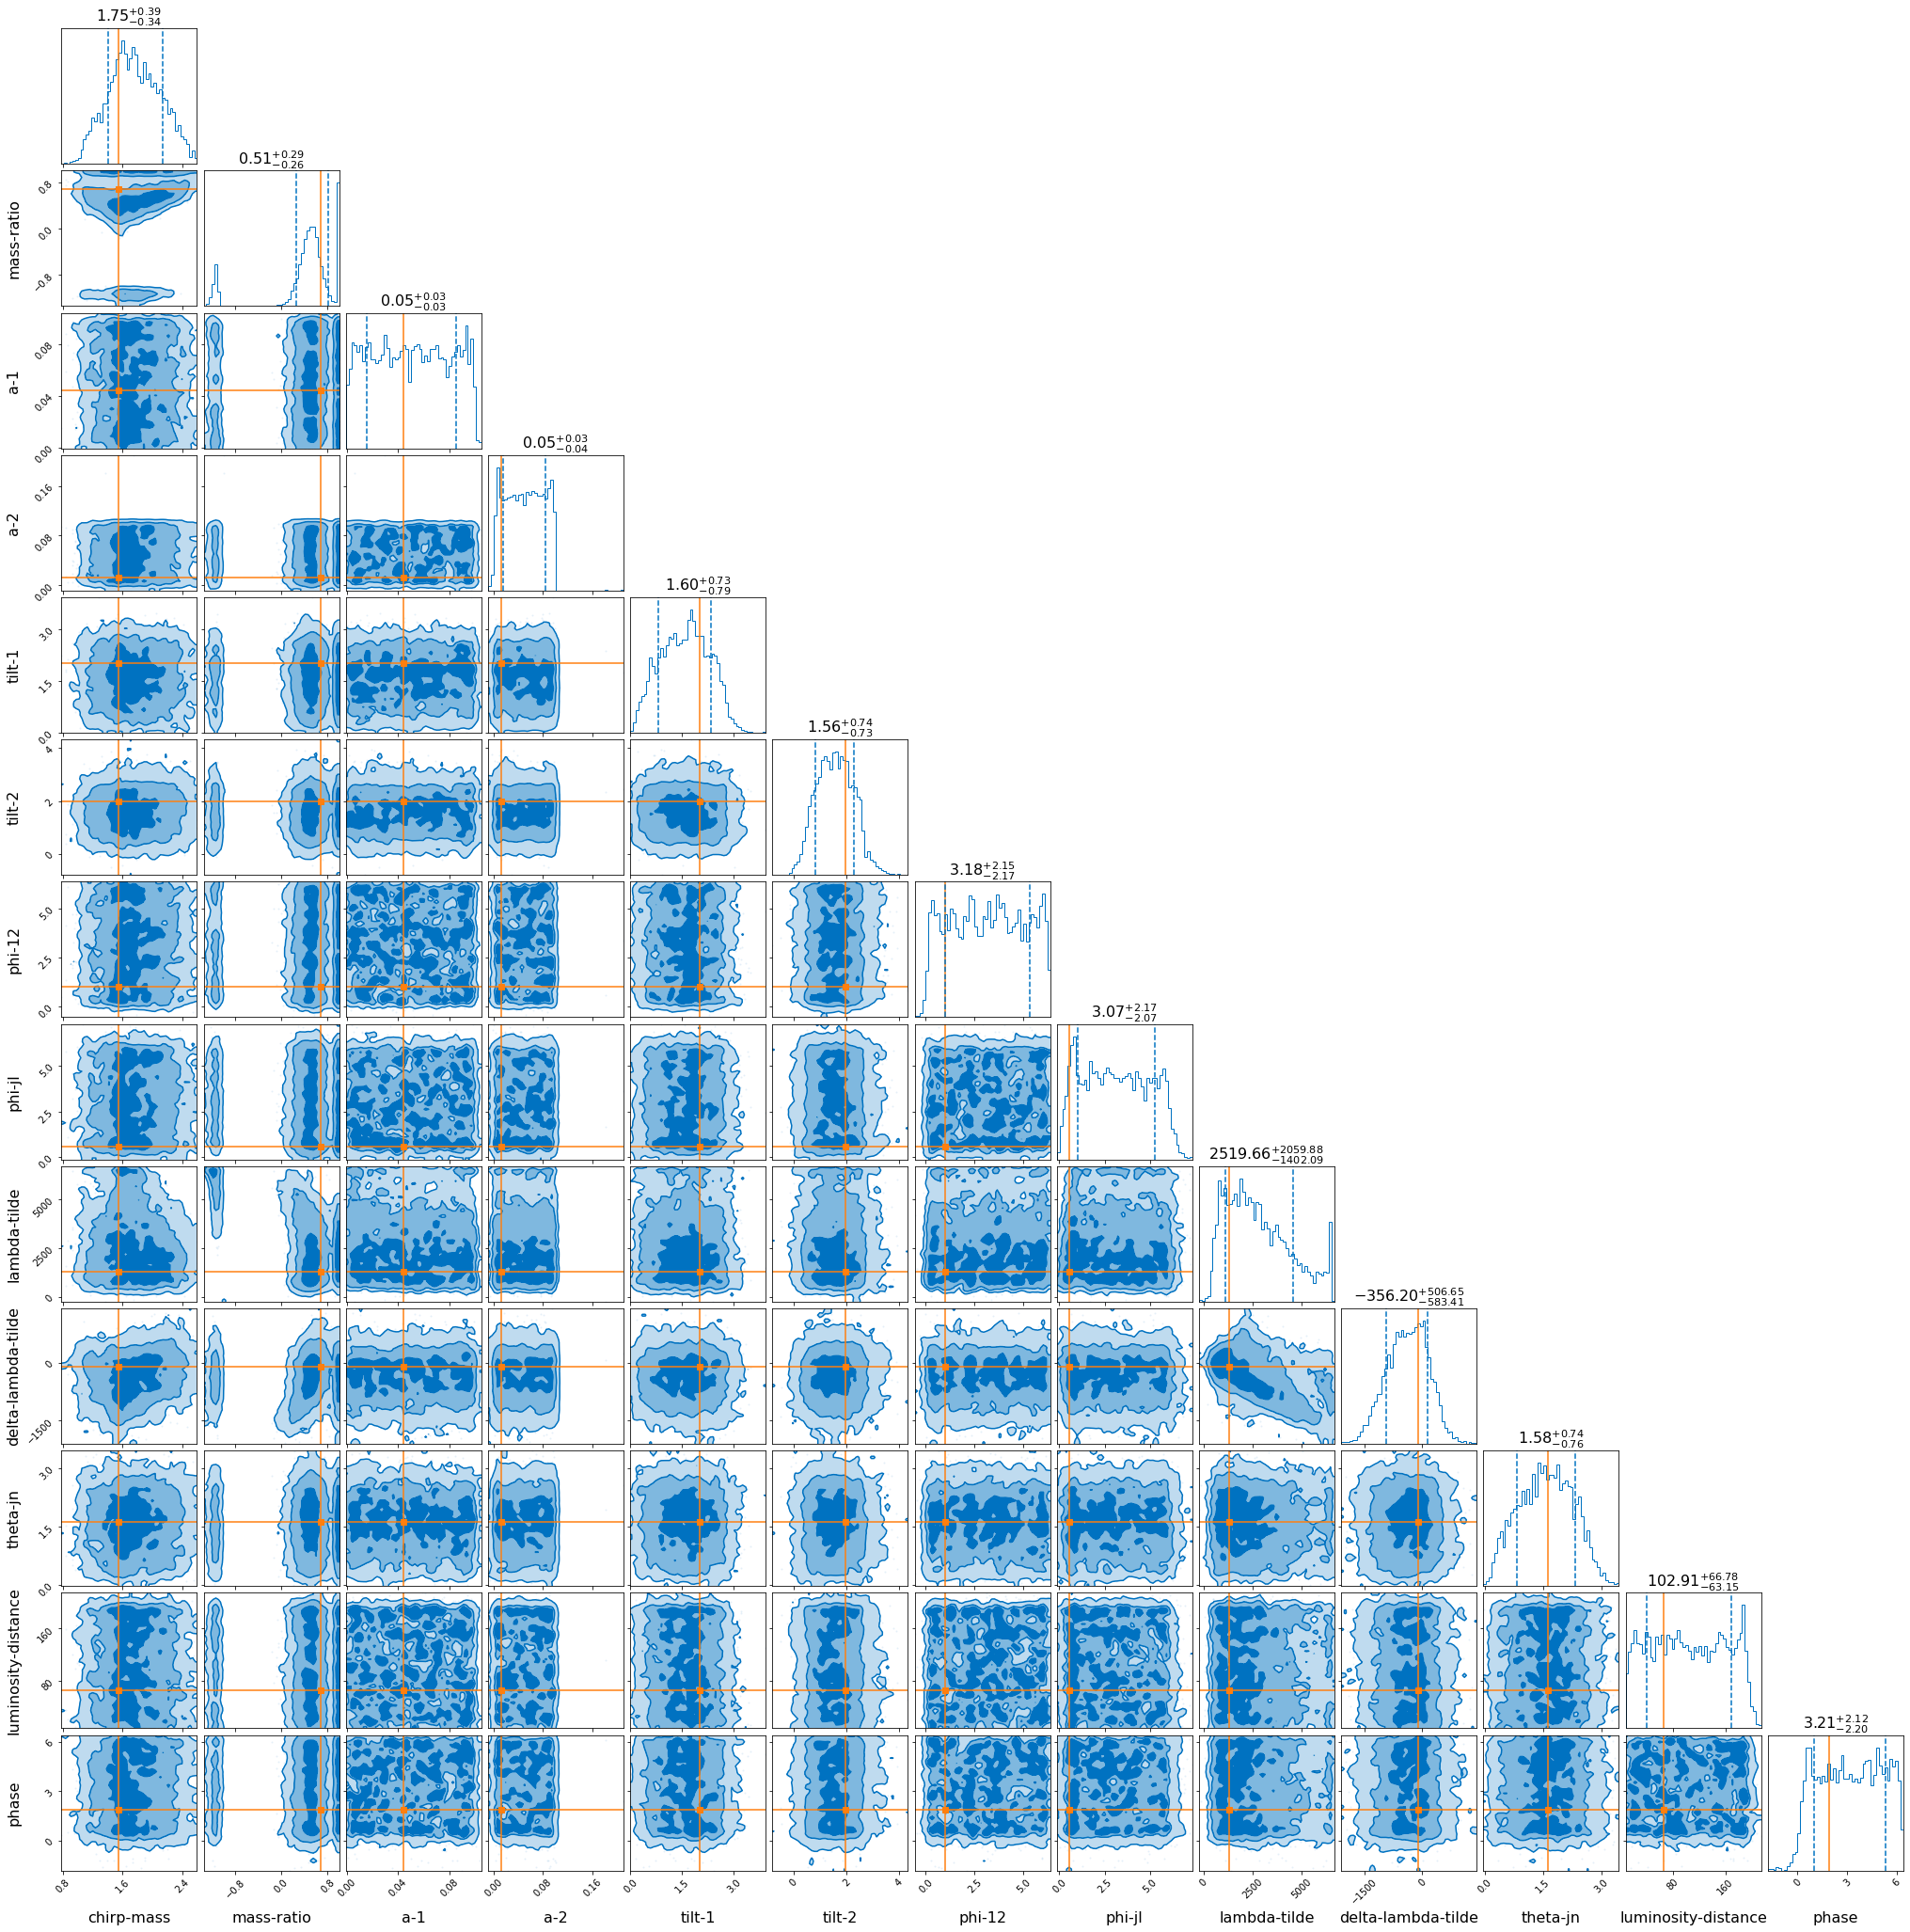

In [93]:
injdict = {}
for i,paraname in enumerate(config_dict['data_generator_parameters']['context_parameter_names']):
    injdict[paraname] = dataset_valid[0][0][i].cpu()

result.injection_parameters = injdict
filename =  f"{config_path}/corner{look_index}.png"

plot_params = result.injection_parameters
plot_params.pop('ra')
plot_params.pop('dec')
plot_params.pop('psi')
plot_params.pop('geocent_time')
fig = result.plot_corner(parameters=plot_params, save=False, filename = filename)





In [94]:
result_prior = bilby.core.result.read_in_result('/home/qian.hu/mlpe/river/scripts/outputs/prior_samples.pkl')
results = [result, result_prior]


/home/qian.hu/.conda/envs/myigwn-py39/lib/python3.9/site-packages/corner/corner.py:806: UserWarning: The following kwargs were not used by contour: 'linestyle'
  ax.contour(X2, Y2, H2.T, V, **contour_kwargs)
/home/qian.hu/.conda/envs/myigwn-py39/lib/python3.9/site-packages/corner/corner.py:806: UserWarning: The following kwargs were not used by contour: 'linestyle'
  ax.contour(X2, Y2, H2.T, V, **contour_kwargs)


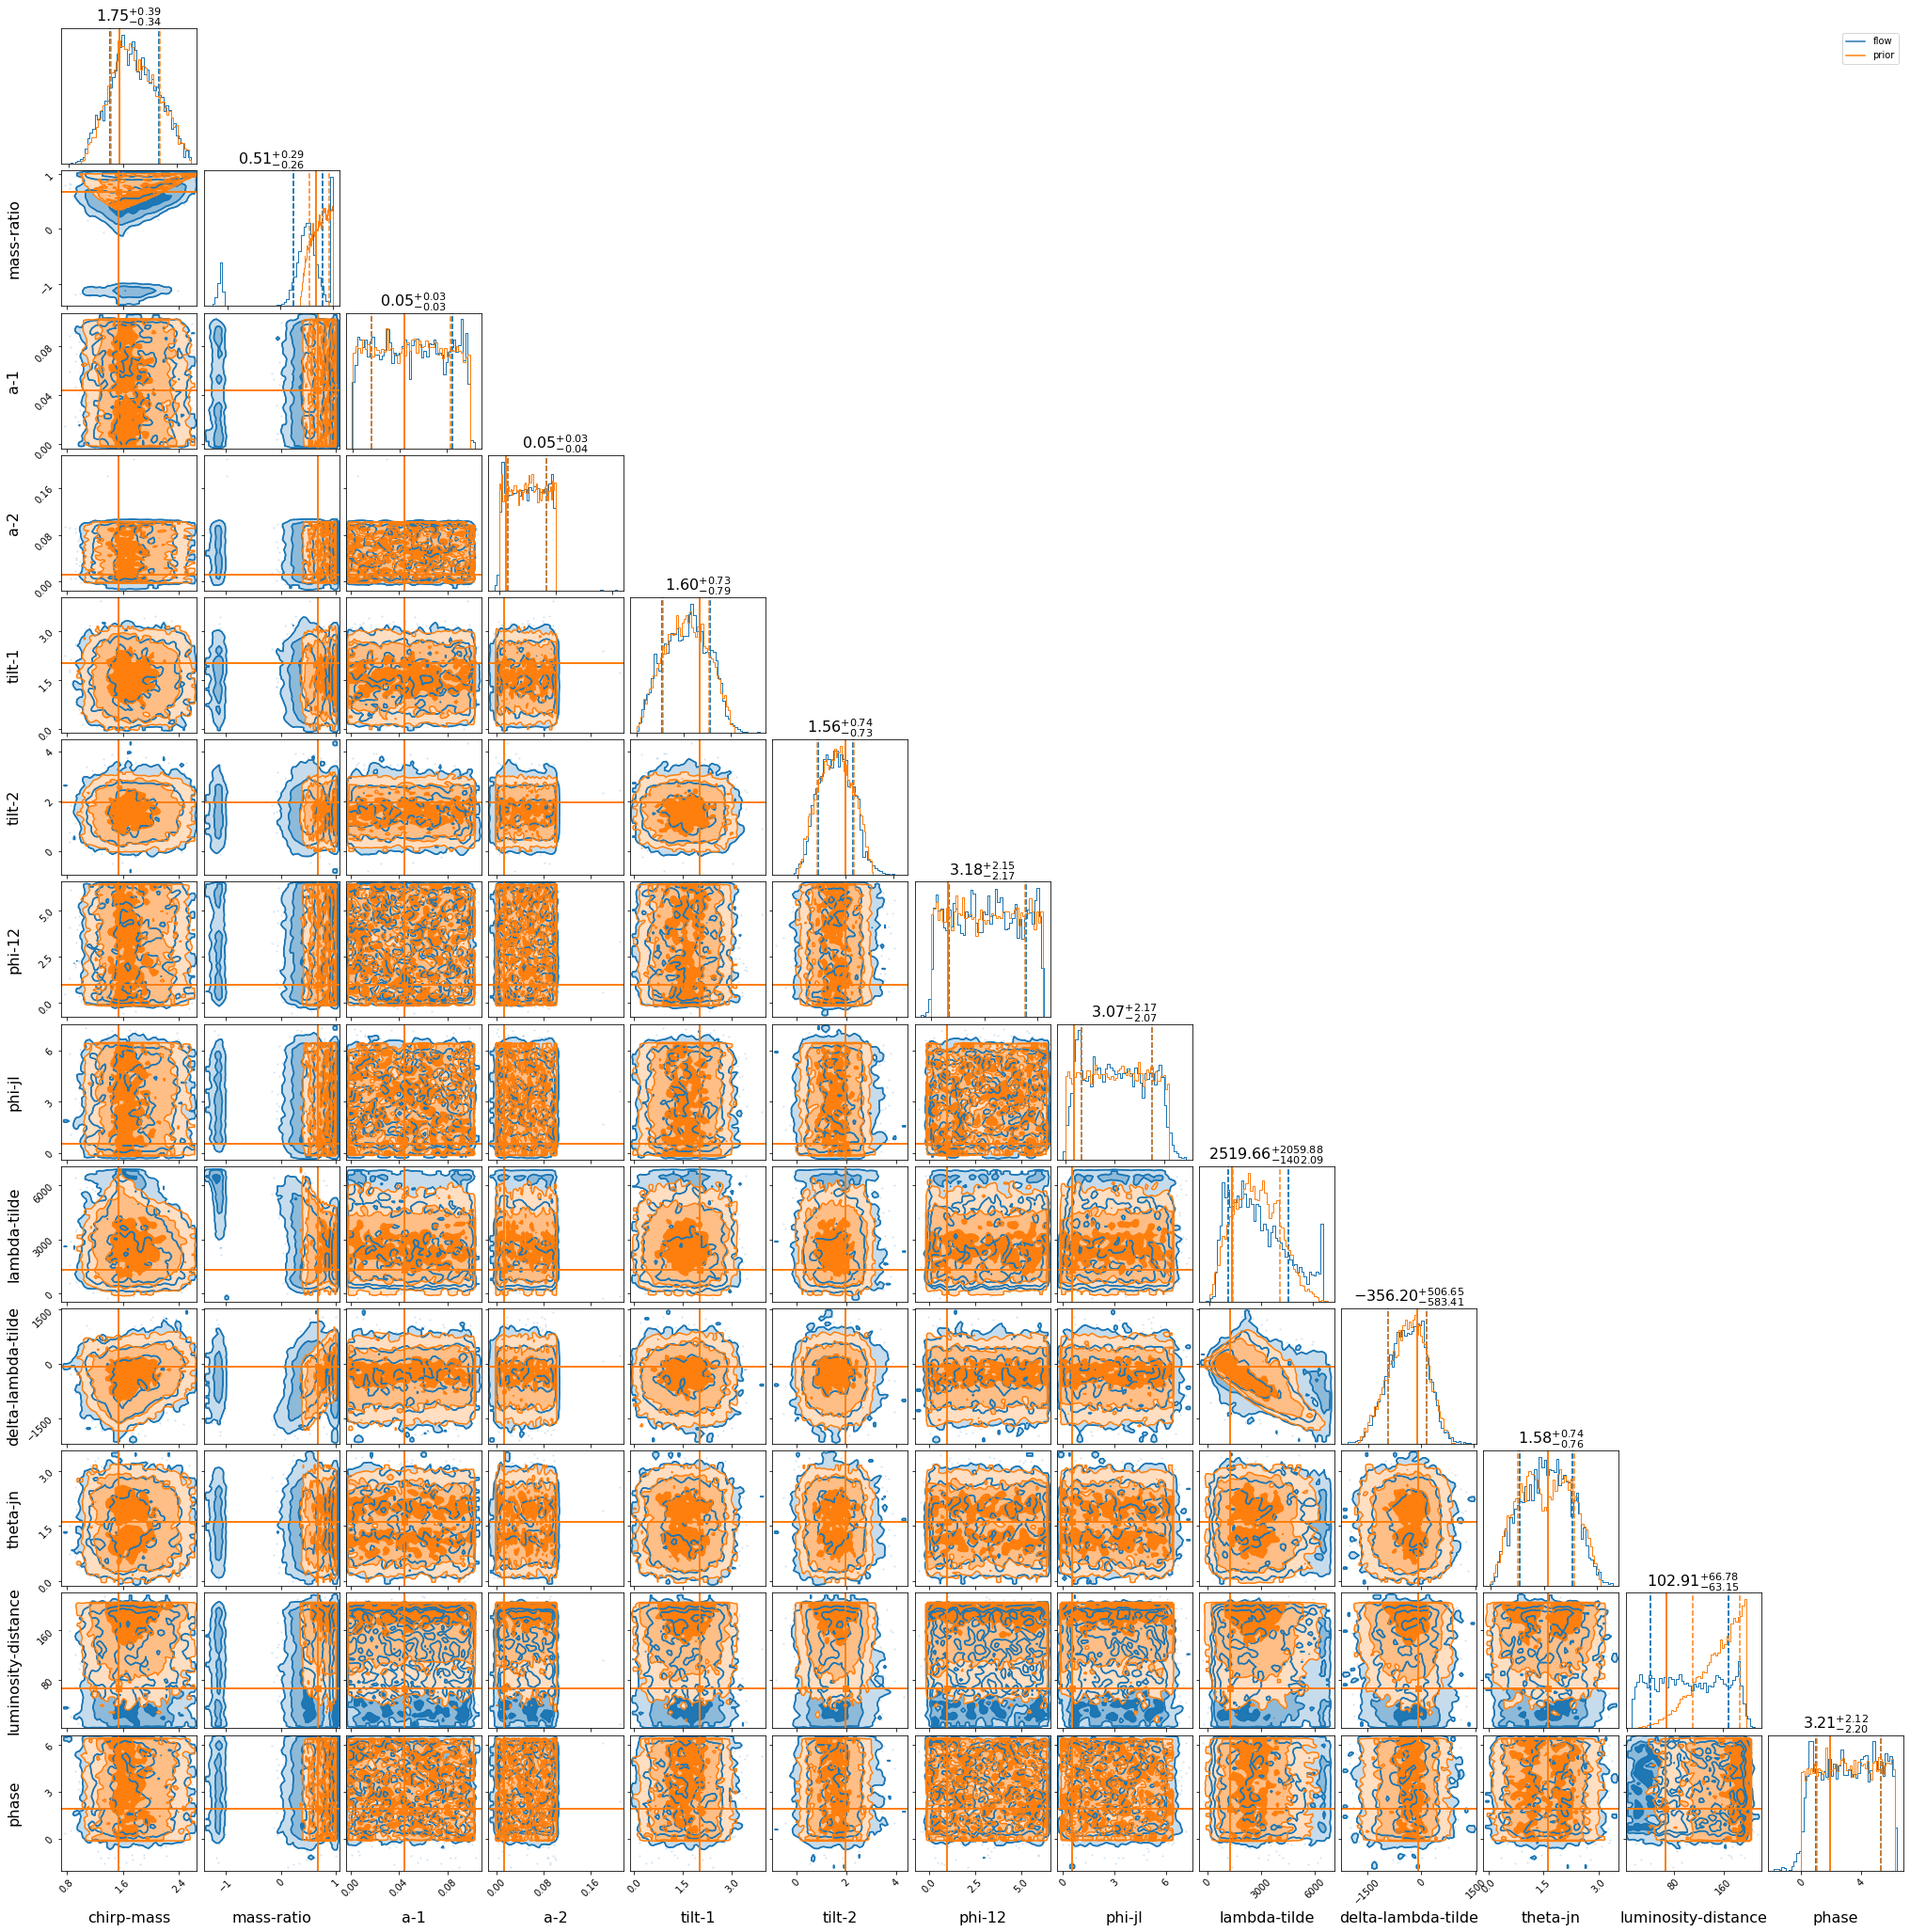

In [95]:
fig = bilby.core.result.plot_multiple(results, parameters=plot_params, filename=None, labels=['flow', 'prior'], colours=None, save=False, evidences=False, corner_labels=None, linestyles=None)

